In [ ]:
 import pandas as pd
 df_train = pd.read_csv("/content/train.csv", delimiter='\t')
 df_train

,score,sentence1,sentence2
0,5.00,A plane is taking off.,An air plane is taking off.
1,3.80,A man is playing a large flute.,A man is playing a flute.
2,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,2.60,Three men are playing chess.,Two men are playing chess.
4,4.25,A man is playing the cello.,A man seated is playing the cello.
...,...,...,...
5706,0.00,Severe Gales As Storm Clodagh Hits Britain,Merkel pledges NATO solidarity with Latvia
5707,0.00,Dozens of Egyptians hostages taken by Libyan t...,Egyptian boat crash death toll rises as more b...
5708,0.00,President heading to Bahrain,President Xi: China to continue help to fight ...
5709,0.00,"China, India vow to further bilateral ties",China Scrambles to Reassure Jittery Stock Traders


In [ ]:
df_train.describe()

,score
count,5711.000000
mean,2.698543
std,1.466207
min,0.000000
25%,1.500000
50%,3.000000
75%,3.800000
max,5.000000


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5711 entries, 0 to 5710
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      5711 non-null   float64
 1   sentence1  5711 non-null   object 
 2   sentence2  5708 non-null   object 
dtypes: float64(1), object(2)
memory usage: 134.0+ KB


In [ ]:
 import pandas as pd
 df_test = pd.read_csv("/content/dev.csv", delimiter='\t')
 df_test

,score,setence1,sentence2
0,5.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.
1,4.75,A young child is riding a horse.,A child is riding a horse.
2,5.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.
3,2.40,A woman is playing the guitar.,A man is playing guitar.
4,2.75,A woman is playing the flute.,A man is playing a flute.
...,...,...,...
1465,2.00,Scientists prove there is water on Mars,Has Nasa discovered water on Mars?
1466,0.00,Pranab stresses need to strive for peace by na...,WTO: India regrets action of developed nations
1467,2.00,Volkswagen skids into red in wake of pollution...,"Volkswagen's ""gesture of goodwill"" to diesel o..."
1468,0.00,Obama is right: Africa deserves better leadership,Obama waiting for midterm to name attorney gen...


In [ ]:
df_test.describe()


,score
count,1470.000000
mean,2.344035
std,1.502124
min,0.000000
25%,1.000000
50%,2.400000
75%,3.600000
max,5.000000


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      1470 non-null   float64
 1   setence1   1470 non-null   object 
 2   sentence2  1468 non-null   object 
dtypes: float64(1), object(2)
memory usage: 34.6+ KB


In [ ]:
df_test.columns

Index(['score', 'setence1', 'sentence2'], dtype='object')

In [ ]:
df_test.columns = ['score', 'sentence1', 'sentence2']
df_test.to_csv('dev.csv', sep="\t",index=False)

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path, delimiter='\t')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # self.sent1_max = 0
        # self.sent2_max = 0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        sentence1 = ( sample["sentence1"] if type(sample["sentence1"]) !=float  else "" )
        sentence2 = ( sample["sentence2"] if type(sample["sentence2"]) !=float  else "" )
        # self.sent1_max = max(self.sent1_max,len(sentence1.split()))
        # self.sent2_max = max(self.sent2_max,len(sentence2.split()))
        max_len = 512
        combined_sentence = sentence1 + "[SEP]" + sentence2
        segment_id = torch.hstack([torch.zeros((1,len(sentence1.split())+2)),torch.ones((1,len(sentence2.split())+1)),torch.zeros((1,max_len-(len(sentence1.split())+2)-(len(sentence2.split())+1)))]).long()

        encoded_input = self.tokenizer(combined_sentence, return_tensors='pt',padding ="max_length",max_length=max_len,truncation=True)

        encoded_input['token_type_ids'] = segment_id

        score = sample['score']

        # Preprocessing, tokenization, or any other operations can be performed here
        # For simplicity, let's just return the text and label as tensors
        return encoded_input["input_ids"].squeeze(0), encoded_input["token_type_ids"].squeeze(0) ,encoded_input["attention_mask"].squeeze(0), torch.tensor(score/5.0)


# Example usage:

file_path = "/content/train.csv"
train_custom_dataset = CustomDataset(file_path)

file_path = "/content/dev.csv"
dev_custom_dataset = CustomDataset(file_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
print(len(train_custom_dataset))
print(len(dev_custom_dataset))

5711
1470


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd



In [ ]:

train_loader = DataLoader(train_custom_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_custom_dataset, batch_size=16, shuffle=False)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

# Training Loop
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from tqdm import tqdm
import torch
from scipy.stats import pearsonr

# Define lists to store training and validation loss
train_losses = []
val_losses = []
pearson_coeffs = []  # List to store Pearson correlation coefficients

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")
    for step, (input_ids, token_type_ids, attention_mask, labels) in progress_bar:
        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits.flatten(), labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': total_loss / (step + 1)})

    # Validation
    model.eval()
    with torch.no_grad():
        total_dev_loss = 0
        predictions = []
        actuals = []
        for input_ids, token_type_ids, attention_mask, labels in dev_loader:
            input_ids = input_ids.to(device)
            token_type_ids = token_type_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
            total_dev_loss += outputs.loss.item()

            # Collect predictions and actual scores
            predictions.extend(outputs.logits.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy().flatten())

        average_dev_loss = total_dev_loss / len(dev_loader)
        print(f"Epoch {epoch+1}, Average Validation Loss: {average_dev_loss}")

        # Calculate Pearson correlation
        pearson_corr, _ = pearsonr(predictions, actuals)
        pearson_coeffs.append(pearson_corr)  # Store Pearson correlation coefficient

        print(f"Epoch {epoch+1}, Pearson correlation: {pearson_corr}")

        # Store training and validation loss
        train_losses.append(total_loss / len(train_loader))
        val_losses.append(average_dev_loss)

# Save model


Epoch 1: 100%|██████████| 357/357 [08:05<00:00,  1.36s/it, Loss=0.0421]


Epoch 1, Average Validation Loss: 0.022566406359907077
Epoch 1, Pearson correlation: 0.8716544355709143


Epoch 2: 100%|██████████| 357/357 [08:19<00:00,  1.40s/it, Loss=0.017]


Epoch 2, Average Validation Loss: 0.026328642647015586
Epoch 2, Pearson correlation: 0.8645291621015067


Epoch 3: 100%|██████████| 357/357 [08:19<00:00,  1.40s/it, Loss=0.0106]


Epoch 3, Average Validation Loss: 0.0283057278687114
Epoch 3, Pearson correlation: 0.8678600597411845


Epoch 4: 100%|██████████| 357/357 [08:19<00:00,  1.40s/it, Loss=0.00748]


Epoch 4, Average Validation Loss: 0.024155432764603767
Epoch 4, Pearson correlation: 0.8737040112377494


Epoch 5: 100%|██████████| 357/357 [08:19<00:00,  1.40s/it, Loss=0.00595]


Epoch 5, Average Validation Loss: 0.02407021903674491
Epoch 5, Pearson correlation: 0.8728579242297657


Epoch 6: 100%|██████████| 357/357 [08:19<00:00,  1.40s/it, Loss=0.00518]


Epoch 6, Average Validation Loss: 0.029539205352428884
Epoch 6, Pearson correlation: 0.8796320502618794


Epoch 7: 100%|██████████| 357/357 [08:19<00:00,  1.40s/it, Loss=0.00463]


Epoch 7, Average Validation Loss: 0.02287640958998917
Epoch 7, Pearson correlation: 0.8750358885116751


Epoch 8: 100%|██████████| 357/357 [08:19<00:00,  1.40s/it, Loss=0.00389]


Epoch 8, Average Validation Loss: 0.021533884401865055
Epoch 8, Pearson correlation: 0.8801475381537497


Epoch 9: 100%|██████████| 357/357 [08:19<00:00,  1.40s/it, Loss=0.00392]


Epoch 9, Average Validation Loss: 0.03024410260148185
Epoch 9, Pearson correlation: 0.8773471669580482


Epoch 10: 100%|██████████| 357/357 [08:20<00:00,  1.40s/it, Loss=0.00407]


Epoch 10, Average Validation Loss: 0.026867456650163733
Epoch 10, Pearson correlation: 0.8744052823617103


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# model.save_pretrained("/content/drive/MyDrive/NLP_A3_Model_A/")

In [ ]:
# import pickle
# filename = "/content/drive/MyDrive/A3_NLP/A/train_val.pth"
# with open(filename, 'wb') as outp:  # Overwrites any existing file.
#         pickle.dump([train_losses,val_losses], outp)


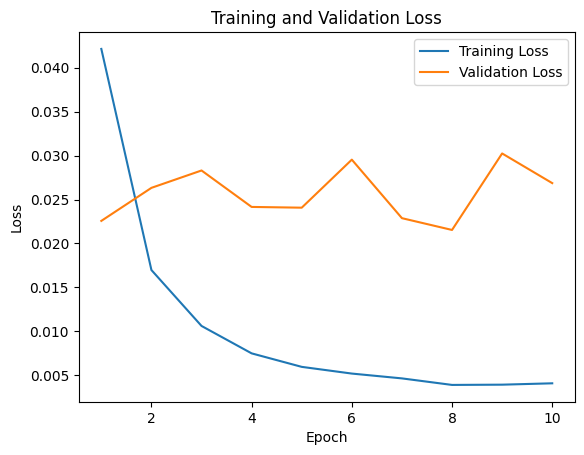

Pearson correlation coefficients:
Epoch 1: 0.8716544355709143
Epoch 2: 0.8645291621015067
Epoch 3: 0.8678600597411845
Epoch 4: 0.8737040112377494
Epoch 5: 0.8728579242297657
Epoch 6: 0.8796320502618794
Epoch 7: 0.8750358885116751
Epoch 8: 0.8801475381537497
Epoch 9: 0.8773471669580482
Epoch 10: 0.8744052823617103


In [ ]:
model.save_pretrained("/content/drive/MyDrive/NLP_A3_Model_A/")

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print Pearson correlation coefficients
print("Pearson correlation coefficients:")
for epoch, pearson_coeff in enumerate(pearson_coeffs, start=1):
    print(f"Epoch {epoch}: {pearson_coeff}")


Mounted at /content/drive


# Inference

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
model =model.from_pretrained("/content/drive/MyDrive/NLP_A3_Model_A")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer


test_data = pd.read_csv("/content/sample_test.csv", delimiter='\t')
test_data.columns = ['id', 'sentence1', 'sentence2']
test_data.to_csv('sample_test.csv', sep="\t",index=False)


class CustomDatasett(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path, delimiter='\t')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # self.sent1_max = 0
        # self.sent2_max = 0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        sentence1 = ( sample["sentence1"] if type(sample["sentence1"]) !=float  else "" )
        sentence2 = ( sample["sentence2"] if type(sample["sentence2"]) !=float  else "" )
        # self.sent1_max = max(self.sent1_max,len(sentence1.split()))
        # self.sent2_max = max(self.sent2_max,len(sentence2.split()))
        max_len = 512
        combined_sentence = sentence1 + "[SEP]" + sentence2
        print(combined_sentence)
        segment_id = torch.hstack([torch.zeros((1,len(sentence1.split())+2)),torch.ones((1,len(sentence2.split())+1)),torch.zeros((1,max_len-(len(sentence1.split())+2)-(len(sentence2.split())+1)))]).long()

        encoded_input = self.tokenizer(combined_sentence, return_tensors='pt',padding ="max_length",max_length=max_len,truncation=True)

        encoded_input['token_type_ids'] = segment_id



        # Preprocessing, tokenization, or any other operations can be performed here
        # For simplicity, let's just return the text and label as tensors
        return encoded_input["input_ids"], encoded_input["token_type_ids"] ,encoded_input["attention_mask"]


# Example usage:

file_path = "/content/sample_test.csv"
test_custom_dataset = CustomDatasett(file_path)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
scores = []
for i,j,k in test_custom_dataset:
  scores.append( (model(input_ids=i, token_type_ids=j, attention_mask=k).logits[0][0]*5).item())

test_data['score'] = scores
# Predict whether the two sentences belong to the same category or not


A man with a hard hat is dancing.[SEP]A man wearing a hard hat is dancing.
A young child is riding a horse.[SEP]A child is riding a horse.
A man is feeding a mouse to a snake.[SEP]The man is feeding a mouse to the snake.
A woman is playing the guitar.[SEP]A man is playing guitar.
A woman is playing the flute.[SEP]A man is playing a flute.
A woman is cutting an onion.[SEP]A man is cutting onions.


In [ ]:
test_data = test_data[['id', 'score', 'sentence1', 'sentence2']]

In [ ]:
test_data.to_csv('/content/sample_test_out.csv', sep="\t",index=False)